### Before this assignment, my knowledge of diffusion models was limited to a basic understanding of how they operate and familiarity with some models that utilize diffusion, such as Dalle. However, I hadn't had any practical experience with them prior to this task.

In [ ]:
!pip install accelerate diffusers

In [ ]:
from diffusers import StableDiffusionPipeline , DiffusionPipeline , StableDiffusionXLPipeline, EulerDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file


from PIL import Image
import matplotlib.pyplot as plt
import torch
import time

### Two prompts are used through-out this task


*  **First prompt** -- has a good detail of person as well as the background, ***outdoor setting***
*  **Second prompt** -- has a great detail of person but less about background , ***studio setting***



In [ ]:
# Define text prompt
prompt =  "A young woman with short brown hair, freckles, and a warm smile, sitting on a park bench surrounded by colorful autumn leaves."
prompt1 = "indian female supermodel wearing white t-shirt, soft neutral expression, long and wavy black hair, symmetrical face, front facing, looking at camera, studio lighting, 8k. Dramatic, professional photography. UHD."

#### For base-line we use two popular mid-level level models, both output image size is of 512 * 512

*   runwayml/stable-diffusion-v1-5
*   CompVis/stable-diffusion-v1-4



In [ ]:
# Load model and tokenizer

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",torch_dtype=torch.float16)
#pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe.to("cuda")

In [ ]:
def generate_imges(inf_steps = 100):
    start = time.time()
    image = pipe(prompt, num_inference_steps=inf_steps).images[0]
    image1 = pipe(prompt1, num_inference_steps=inf_steps).images[0]
    #image = pipe(prompt, num_inference_steps=50,height=2048, width=2048).images[0]
    #image1 = pipe(prompt1, num_inference_steps=50,height=2048, width=2048).images[0]
    end = time.time()
    print("Time to genetate : ", end-start)
    return image,image1

In [ ]:
# Show both Generate Images
def show_images(image,image1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image)
    axs[1].imshow(image1)
    fig.suptitle('Image is from promt-1                                               Image is from prompt-2')
    for ax in axs.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
image, image1 = generate_imges(inf_steps = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Time to genetate :  33.07760000228882


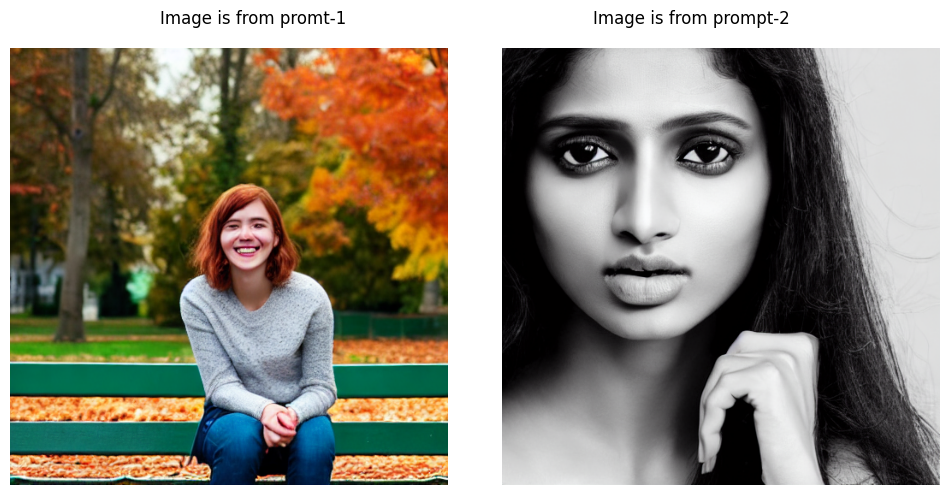

In [ ]:
show_images(image,image1)

*   Images are of poor Quality and doesn't look realistic when background is complex
*   Images are of better quality and look some-what realistic when background is not so complex



### Upscaling the image to 2048 * 2048

In [ ]:
# Upscaling the image (2048 * 2048)
def resize_images(image, image1):
    new_size = (2048, 2048)
    resized_image1 = image.resize(new_size, resample=Image.LANCZOS)
    resized_image2 = image1.resize(new_size, resample=Image.LANCZOS)
    return resized_image1, resized_image2

Images in 2048 * 2048


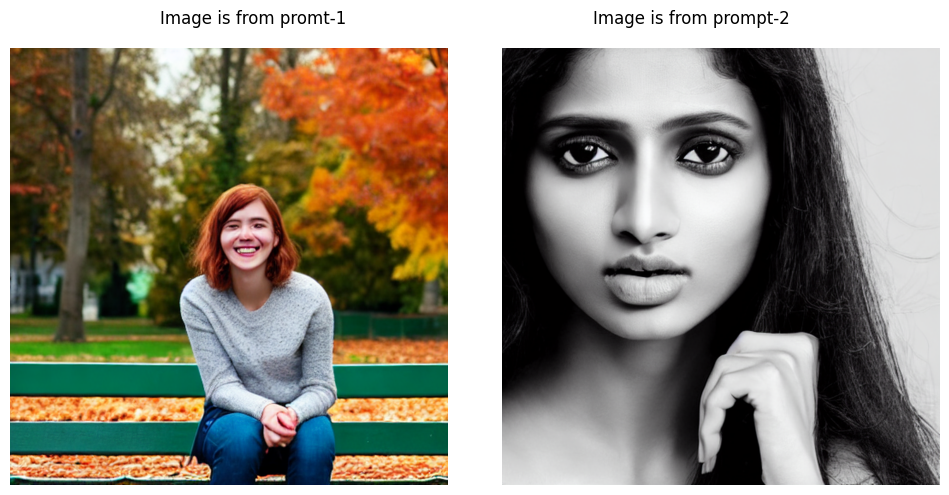

In [ ]:
print("Images in 2048 * 2048")
re_image,re_image1 = resize_images(image, image1)
show_images(re_image, re_image1)

## For improving the quality of images and prioritizing photorealism, steerability

we use popular stabilityai/stable-diffusion-xl-base-1.0 model which genetate high quality 1024 * 1024 image

In [ ]:
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

In [ ]:
image, image1 = generate_imges(inf_steps=50)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Time to genetate :  88.2145562171936


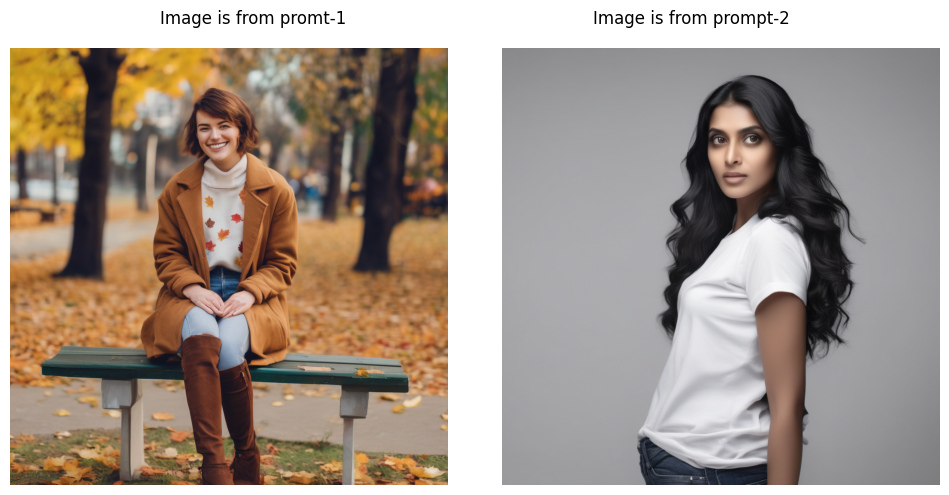

In [ ]:
show_images(image,image1)

Images in 2048 * 2048


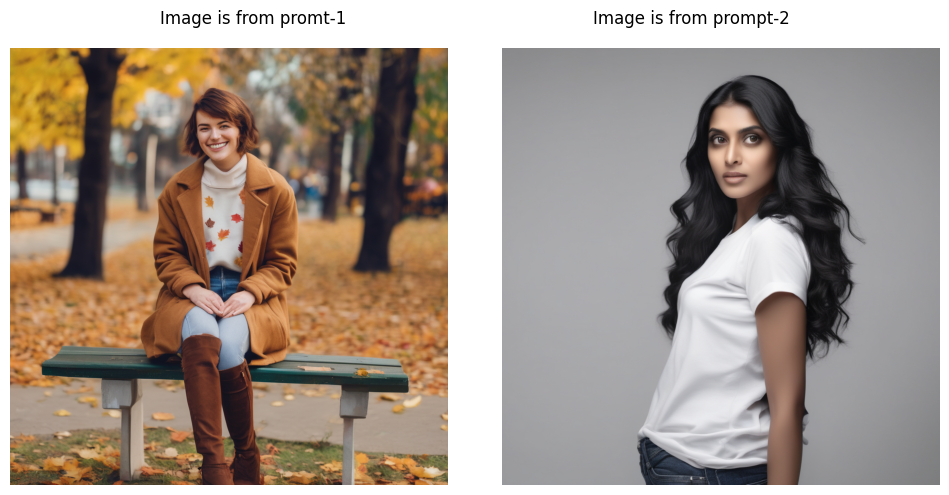

In [ ]:
print("Images in 2048 * 2048")
re_image,re_image1 = resize_images(image, image1)
show_images(re_image, re_image1)

### For Improving Inference Time
We used "**ByteDance/SDXL-Lightning**" which gove great results in just 2/4/8 results. we have used 8_step checkpoints

In [ ]:
base = "stabilityai/stable-diffusion-xl-base-1.0"
repo = "ByteDance/SDXL-Lightning"
ckpt = "sdxl_lightning_8step_unet.safetensors"

In [ ]:
# Load model.
unet = UNet2DConditionModel.from_config(base, subfolder="unet").to("cuda", torch.float16)
unet.load_state_dict(load_file(hf_hub_download(repo, ckpt), device="cuda"))
pipe = StableDiffusionXLPipeline.from_pretrained(base, unet=unet, torch_dtype=torch.float16, variant="fp16").to("cuda")


/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all o

sdxl_lightning_8step_unet.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:

pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

In [ ]:
start = time.time()
img = pipe(prompt, num_inference_steps=8, guidance_scale=0).images[0]
img1 = pipe(prompt1, num_inference_steps=8, guidance_scale=0).images[0]
end = time.time()
print("Time to generate :", end-start)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate : 13.003561735153198


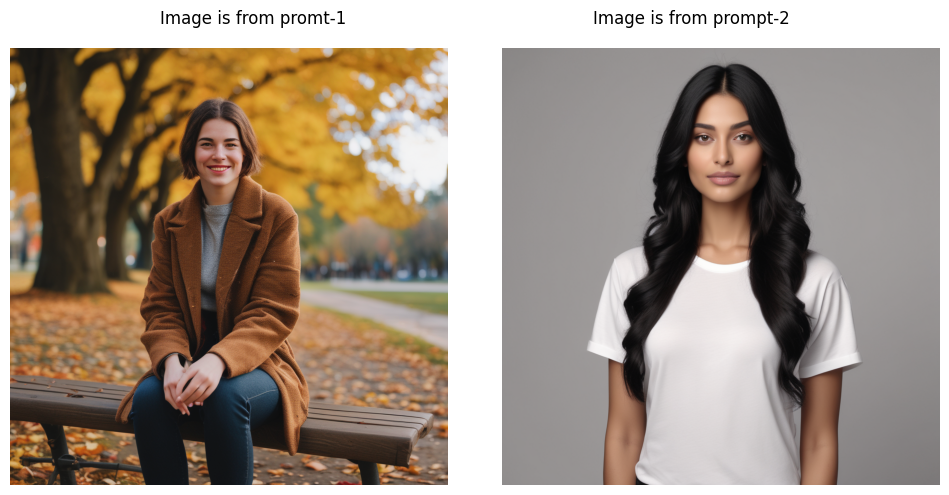

In [ ]:
show_images(img,img1)

Images in 2048 * 2048


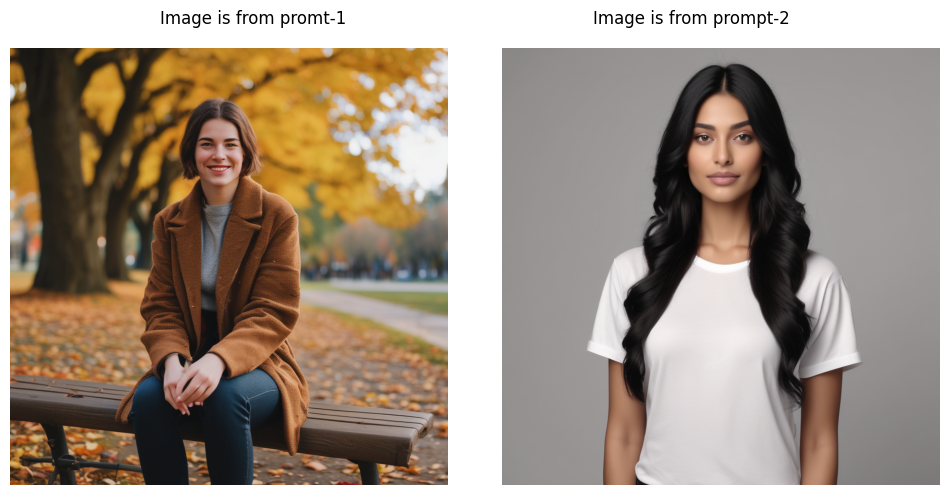

In [ ]:
print("Images in 2048 * 2048")
re_image,re_image1 = resize_images(img, img1)
show_images(re_image, re_image1)

### Lora "ByteDance/SDXL-Lightning"

In [ ]:
base = "stabilityai/stable-diffusion-xl-base-1.0"
repo = "ByteDance/SDXL-Lightning"
ckpt = "sdxl_lightning_8step_lora.safetensors"

In [ ]:
# Load model.
pipe = StableDiffusionXLPipeline.from_pretrained(base, torch_dtype=torch.float16, variant="fp16").to("cuda")
pipe.load_lora_weights(hf_hub_download(repo, ckpt))
pipe.fuse_lora()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

sdxl_lightning_8step_lora.safetensors:   0%|          | 0.00/394M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/loaders/lora.py:1078: FutureWarning: `fuse_text_encoder_lora` is deprecated and will be removed in version 0.27. You are using an old version of LoRA backend. This will be deprecated in the next releases in favor of PEFT make sure to install the latest PEFT and transformers packages in the future.
  deprecate("fuse_text_encoder_lora", "0.27", LORA_DEPRECATION_MESSAGE)


In [ ]:
start = time.time()
img = pipe(prompt, num_inference_steps=8, guidance_scale=0).images[0]
img1 = pipe(prompt1, num_inference_steps=8, guidance_scale=0).images[0]
end = time.time()
print("Time to generate :", end-start)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate : 10.987684965133667


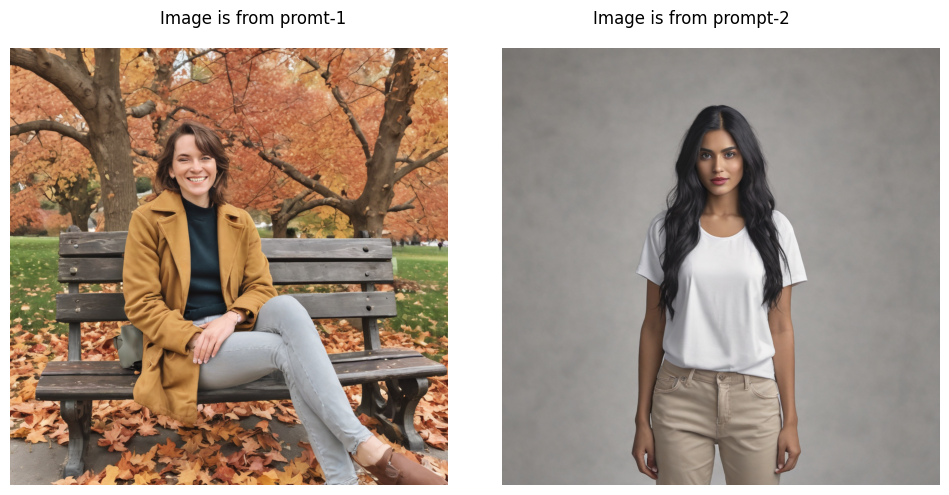

In [ ]:
show_images(img,img1)

Images in 2048 * 2048


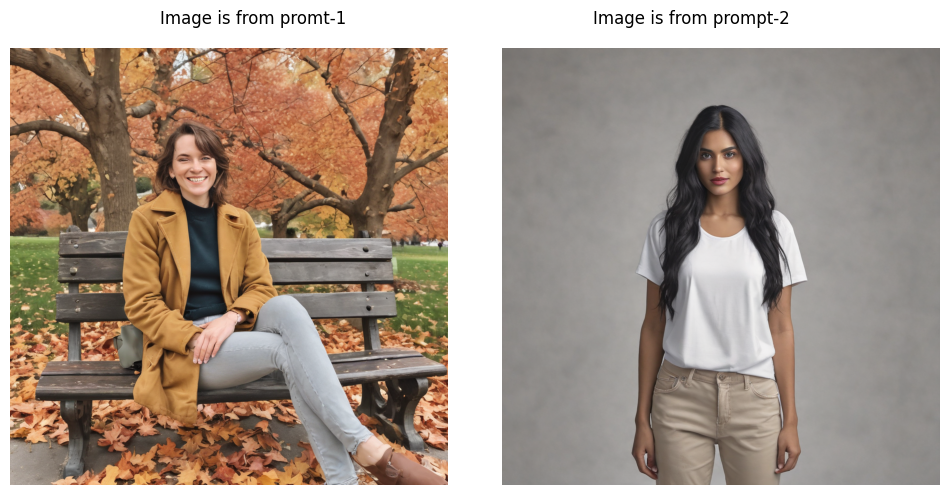

In [ ]:
print("Images in 2048 * 2048")
re_image,re_image1 = resize_images(img, img1)
show_images(re_image, re_image1)